In [2]:
%matplotlib notebook
import sys
sys.path.append("../")
sys.path.append("/mnt/lustre/zhanxiaohang/anaconda3/envs/pytorch041/lib/python3.7/site-packages/")
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import yaml

import time
from scipy import interpolate
import os
import cv2
import requests
from io import BytesIO

#sys.path.append("/mnt/lustre/share/zhanxiaohang/videoseg/lib/pydensecrf")
import pdb
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import flowlib
import models
import utils
import importlib
#importlib.reload(utils)
#importlib.reload(models)


setting = 'ours'

if setting == 'i':
    exp = '../experiments/mpii/static'
elif setting == 'if':
    exp = '../experiments/mpii/cmpvae_skiplayer_fw_noguide_fullcrop_warmup0.05'
elif setting == 'is':
    exp = '../experiments/mpii/cmp_skiplayer_fw_nobg_fullcrop_warmup0.05'
else:
    exp = '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05_2'
#exp = '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05'
#exp = '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05_2'
#exp = '../experiments/mpii/cmsvaev4_skiplayer_fw_nobg_fullcrop_warmup0.05'
#exp = '../experiments/vip+mpii/cmpvae_skiplayer_fw_nobg'
#exp = '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05_longiter'

if exp == '../experiments/vip+mpii/cmpvae_skiplayer_fw_nobg':
    load_iter = 64000
elif exp == '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05_longiter':
    load_iter = 42000
else:
    load_iter = 30000


config = "{}/config.yaml".format(exp)

#val_list = '/mnt/lustre/share/panxingang/MPII/lists/train_list_skip5_s2//randval.txt'
val_list = '/mnt/lustre/share/panxingang/MPII/training/all.txt'
#val_list = '/mnt/lustre/share/panxingang/LIP/list/allimg_list.txt'
#val_list = '/mnt/lustre/share/panxingang/LIP_multi/instance-level_human_parsing/list/valimg_list.txt'
#val_list = '/mnt/lustre/share/panxingang/VIP/lists/train_list_flownet2/randval_group1-8_s2.txt'
#val_list = '/mnt/lustre/share/panxingang/yfcc/lists/train_list_840K/randval.txt'
#val_list = '/mnt/lustre/share/panxingang/youtube9000/lists/train_lists_skip10_s2_fw/randval.txt'
#val_list = '/mnt/lustre/share/panxingang/GRAM/lists/train_list/randval.txt'
#val_list = '/mnt/lustre/share/panxingang/tigdog/lists/train_list/randval.txt'

with open(val_list, 'r') as f:
    lines = f.readlines()
    fns = [l.split()[0] for l in lines]

In [3]:
class ArgObj(object):
    def __init__(self):
        pass

class suibian(torch.nn.Module):
    def __init__(self, m):
        super(suibian, self).__init__()
        self.module = m
    def forward(self, input1, input2):
        return self.module(input1, input2)

def image_resize(img, short_size, long_size):
    assert (short_size is None) ^ (long_size is None)
    w, h = img.width, img.height
    if short_size is not None:
        if w < h:
            neww = short_size
            newh = int(short_size / float(w) * h)
        else:
            neww = int(short_size / float(h) * w)
            newh = short_size
    else:
        if w < h:
            neww = int(long_size / float(h) * w)
            newh = long_size
        else:
            neww = long_size
            newh = int(long_size / float(w) * h)
    img = img.resize((neww, newh), Image.BICUBIC)
    return img

def image_crop(img, crop_size):
    pad_h = max(crop_size[0] - img.height, 0)
    pad_w = max(crop_size[1] - img.width, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        border = (pad_w_half, pad_h_half, pad_w - pad_w_half, pad_h - pad_h_half)
        img = ImageOps.expand(img, border=border, fill=(0,0,0))
    hoff = (img.height - crop_size[0]) // 2
    woff = (img.width - crop_size[1]) // 2
    return img.crop((woff, hoff, woff+crop_size[1], hoff+crop_size[0]))

    
class Demo(object):
    def __init__(self, configfn, load_iter):
        args = ArgObj()
        with open(configfn) as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        setattr(args, 'load_iter', load_iter)
        setattr(args, 'exp_path', os.path.dirname(configfn))
        
        args.model['flow_type'] = args.data['flow_type']
        args.model['batch_size'] = args.data['batch_size']
        args.model['spatial_dim'] = args.data['crop_size'][0]
        self.model = models.__dict__[args.model['arch']](args.model, dist_model=False)
        
        self.model.load_state("{}/checkpoints".format(args.exp_path), args.load_iter, False)
        self.model.switch_to('eval')
      
        self.data_mean = args.data['data_mean']
        self.data_div = args.data['data_div']
        
        self.img_transform = transforms.Compose([
            transforms.Normalize(self.data_mean, self.data_div)])

        self.args = args
        
    def def_input(self, image, repeat=1):
        self.rgb = image
        tensor = self.img_transform(torch.from_numpy(np.array(image).astype(np.float32).transpose((2,0,1))))
        self.image = tensor.unsqueeze(0).repeat(repeat,1,1,1)
        self.model.set_input(self.image.cuda(), None, None)

In [32]:
class Draw(object):
    def __init__(self):
        self.demo = Demo(config, load_iter)
    
    def init_image(self, img, idx, dims, iter_mode=True, show_flow=False, masked=True, max_iter=20, score_th=0.005, scale=[1.0], short_size=None, long_size=None, crop_size=None, hid_z=None):
        if short_size == -1:
            short_size = self.demo.args.data['short_size']
        if long_size == -1:
            long_size = self.demo.args.data['long_size']
        img = image_resize(img, short_size, long_size)
        if crop_size is None:
            crop_size = self.demo.args.data['crop_size']
        img = image_crop(img, crop_size)
        self.img = img
        self.idx = idx
        self.dims = dims
        self.iter_mode = iter_mode
        self.max_iter = max_iter
        self.score_th = score_th
        self.hid_z = hid_z
        self.masked = masked
        self.show_flow = show_flow
        self.fig = plt.figure(figsize=(10,10))
        self.ax1 = self.fig.add_subplot(221)
        self.ax2 = self.fig.add_subplot(222)
        self.ax3 = self.fig.add_subplot(223)
        self.ax4 = self.fig.add_subplot(224)
        if show_flow:
            self.fig2 = plt.figure(figsize=(10, 5))
            self.axf2 = []
            for j in range(2):
                self.axf2.append(self.fig2.add_subplot(1,2,1 + j))
                self.axf2[-1].axis('off')
        self.status = self.ax1.text(0, 0, "", va="bottom", ha="left", color='r')
        self.unc_max = self.ax3.text(0, 0, "", va="bottom", ha="left", color='r')
        self.its_max = self.ax4.text(0, 0, "", va="bottom", ha='left', color='r')
        self.ax1.imshow(img, alpha=0.5)
        self.ax2.imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
        self.ax3.imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
        self.ax4.imshow(img)
        self.ax1.axis('off')
        self.ax2.axis('off')
        self.ax3.axis('off')
        self.ax4.axis('off')
        self.demo.def_input(img)
        self.ax1.figure.show()
        
    def polar_plot(self, ax, center, peak_distr, n=36):
        w,h = self.img.width, self.img.height
        bbox = ax.get_position()
        x0, y0 = bbox.x0, bbox.y0
        bh, bw = bbox.height, bbox.width
        sz = 0.05
        nc = [x0 + center[0] / float(w) * bw, y0 + bh - center[1] / float(h) * bh]
        
        ap = self.fig.add_axes([nc[0] - sz / 2, nc[1] - sz / 2, sz, sz], polar=True, frameon=False)
        theta = np.arctan2(-peak_distr[:,1], peak_distr[:,0])
        
        hist, bin_edge = np.histogram(theta, bins=np.arange(-np.pi, np.pi, 2 * np.pi / n))
        bin_center = (bin_edge[:-1] + bin_edge[1:]) / 2
        bar = ap.bar(bin_center, hist, color='r', width=2*np.pi/n, edgecolor='black', linewidth=0.1, bottom=0.0)
        ap.axis('off')

    def on_border(self, pt, margin=5):
        if (pt[0] - 0 < margin or self.img.width - pt[0] < margin 
            or pt[1] - 0 < margin or self.img.height - pt[1] < margin):
            return True
    
    def run(self):
        self.status.set_text("Running")
        self.ax2.figure.canvas.draw()

        tdc = self.demo.model.tendency_map(mode='zero').cpu().numpy().transpose((1,2,0))
        tdc_mask = np.sqrt(np.sum(tdc ** 2, axis=2))
        self.its_max.set_text("{:.3g}".format(tdc_mask.max()))
        tdc_mask = np.clip(tdc_mask * 30, 0, 1)
        self.tendency = flowlib.flow_to_image(np.clip(tdc * 30, -10, 10))
        if setting not in ['i', 'is']:
            if not self.iter_mode:
                mf = self.demo.model.mf_map(self.max_iter, self.score_th).cpu().numpy()
            else:
                self.demo.model.iter_sparse.zero_()
                unc_seq = []
                peak_seq = []
                for j in range(self.max_iter):
                    self.status.set_text("Running iter: {}".format(j))
                    self.demo.model.set_sparse(self.demo.model.iter_sparse)
                    unc, flow_outputs = self.demo.model.eval_uncertainty_dim(
                        std=1, dims=self.dims, sample_num=30, mean_mode="zero", ret_outputs=True)
                    unc = torch.sqrt(unc.pow(2).sum(dim=1, keepdim=True))
                    unc = nn.functional.interpolate(
                        unc, size=self.demo.model.image_input.shape[2:4], mode="bilinear", align_corners=True)
                    flow_outputs = [nn.functional.interpolate(
                        fl, size=self.demo.model.image_input.shape[2:4], mode="bilinear", align_corners=True) for fl in flow_outputs]
                    peak_loc = unc.argmax().item()
                    peak_loc_y = peak_loc // unc.size(3)
                    peak_loc_x = peak_loc % unc.size(3)
                    peak_score = unc[0, 0, peak_loc_y, peak_loc_x].item()
                    #peak_distr = np.array([fl[0,:,peak_loc_y,peak_loc_x].cpu().numpy() for fl in flow_outputs])
                    if peak_score > 0:
                        unc = unc / peak_score
                    self.its_max.set_text('{}'.format(unc.sum()))
                    if self.masked:
                        unc_seq.append(unc * self.demo.model.create_gaussian_mask(peak_loc_y, peak_loc_x, sigma=50))
                    else:
                        unc_seq.append(unc)
                    peak_seq.append([peak_loc_x, peak_loc_y])
                    self.demo.model.iter_sparse[0,:2,peak_loc_y,peak_loc_x] = 0
                    self.demo.model.iter_sparse[0,2:,peak_loc_y,peak_loc_x] = 1
                    unc = np.squeeze(unc.cpu().numpy())
                    self.unc_max.set_text("{:.3g}".format(peak_score))



                    #scale = np.sqrt((peak_distr ** 2).sum(axis=1)).max()
                    #bias = peak_distr.mean(axis=0)
                    #bias = [0, 0]
                    #bias = flow_outputs[j].cpu().numpy().squeeze().mean(axis=(1,2))
    #                 for pd in peak_distr:
    #                     self.ax1.arrow(peak_loc_x, peak_loc_y, 30*(pd[0]-bias[0])/scale, 30*(pd[1]-bias[1])/scale, head_width=2, head_length=5, color='r', alpha=0.5)
                    self.ax3.imshow(np.array(self.img) // 2 + cv2.applyColorMap((unc * 255).astype(np.uint8), 
                                                                            cv2.COLORMAP_JET)[:,:,::-1] // 2)
                    if peak_score < self.score_th:
                        break
                    self.ax1.figure.canvas.draw()
                    #plt.savefig("../output/iter_{}.png".format(j))
    #                 if j == 0:
    #                     for k,fl in enumerate(flow_outputs):
    #                         flow_img = flowlib.flow_to_image(100 * fl.cpu().numpy().squeeze().transpose((1,2,0)))
    #                         cv2.imwrite("../output/flow_outputs_{}.jpg".format(k), flow_img)

                    if j == 0:
                        init_flows = [fl.cpu().numpy().squeeze() for fl in flow_outputs]
                    # exam
                    #self.peak_distr = peak_distr
                    #self.bias = bias
                mf = torch.squeeze(torch.cat(unc_seq, dim=0).max(dim=0)[0]).cpu().numpy()

            for pk in peak_seq:
                px, py = pk
                peak_distr = np.array([fl[:,py,px] for fl in init_flows])
                scale = np.sqrt((peak_distr ** 2).sum(axis=1)).max()
                #bias = peak_distr.mean(axis=0)
                bias = [0, 0]
                self.peak_distr = peak_distr
                if self.on_border(pk):
                    continue
                self.ax1.plot(px, py, 'o', color='g', markersize=3.)
                self.polar_plot(self.ax1, pk, peak_distr, n=45)
    #             for pd in peak_distr:
    #                 self.ax1.arrow(px, py, 15*(pd[0]-bias[0])/scale, 15*(pd[1]-bias[1])/scale, 
    #                                head_width=2, head_length=5, color='g', alpha=0.5)
            if self.show_flow:
                for k, fl in enumerate(init_flows):
                    if k < len(self.axf2):
                        self.axf2[k].imshow(flowlib.flow_to_image(np.clip(fl.transpose((1,2,0)) * 30, -10, 10)))
            self.mf = mf
        
        
        self.ax2.imshow(self.tendency)
        if setting not in ['i', 'is']:
            self.dof = np.array(self.img) // 2 + cv2.applyColorMap((mf * 255).astype(np.uint8), 
                                                                        cv2.COLORMAP_JET)[:,:,::-1] // 2
            self.ax3.imshow(self.dof)
        #self.ax4.imshow(np.array(self.img) // 2 + cv2.applyColorMap((tdc_mask * 255).astype(np.uint8), 
        #                                                            cv2.COLORMAP_JET)[:,:,::-1] // 2)
        self.ax4.figure.canvas.draw()
        
        outdir = "../output/{}/{}".format(self.idx, setting)
        if not os.path.isdir(outdir):
            os.makedirs(outdir)
        self.fig.savefig("{}/total.png".format(outdir), dpi=300)
        self.img.save('{}/img.jpg'.format(outdir))
        cv2.imwrite('{}/tdc.jpg'.format(outdir), self.tendency[:,:,::-1])
        if setting not in ['i', 'is']:
            cv2.imwrite('{}/dof.jpg'.format(outdir), self.dof[:,:,::-1])
        
        if self.show_flow:
            self.fig2.show()
            #self.fig2.savefig("../output/flows.png")
        self.status.set_text("Done")

obj = Draw()

=> loading checkpoint '../experiments/mpii/cmpvae_skiplayer_fw_nobg_fullcrop_warmup0.05_2/checkpoints/ckpt_iter_30000.pth.tar'


<IPython.core.display.Javascript object>


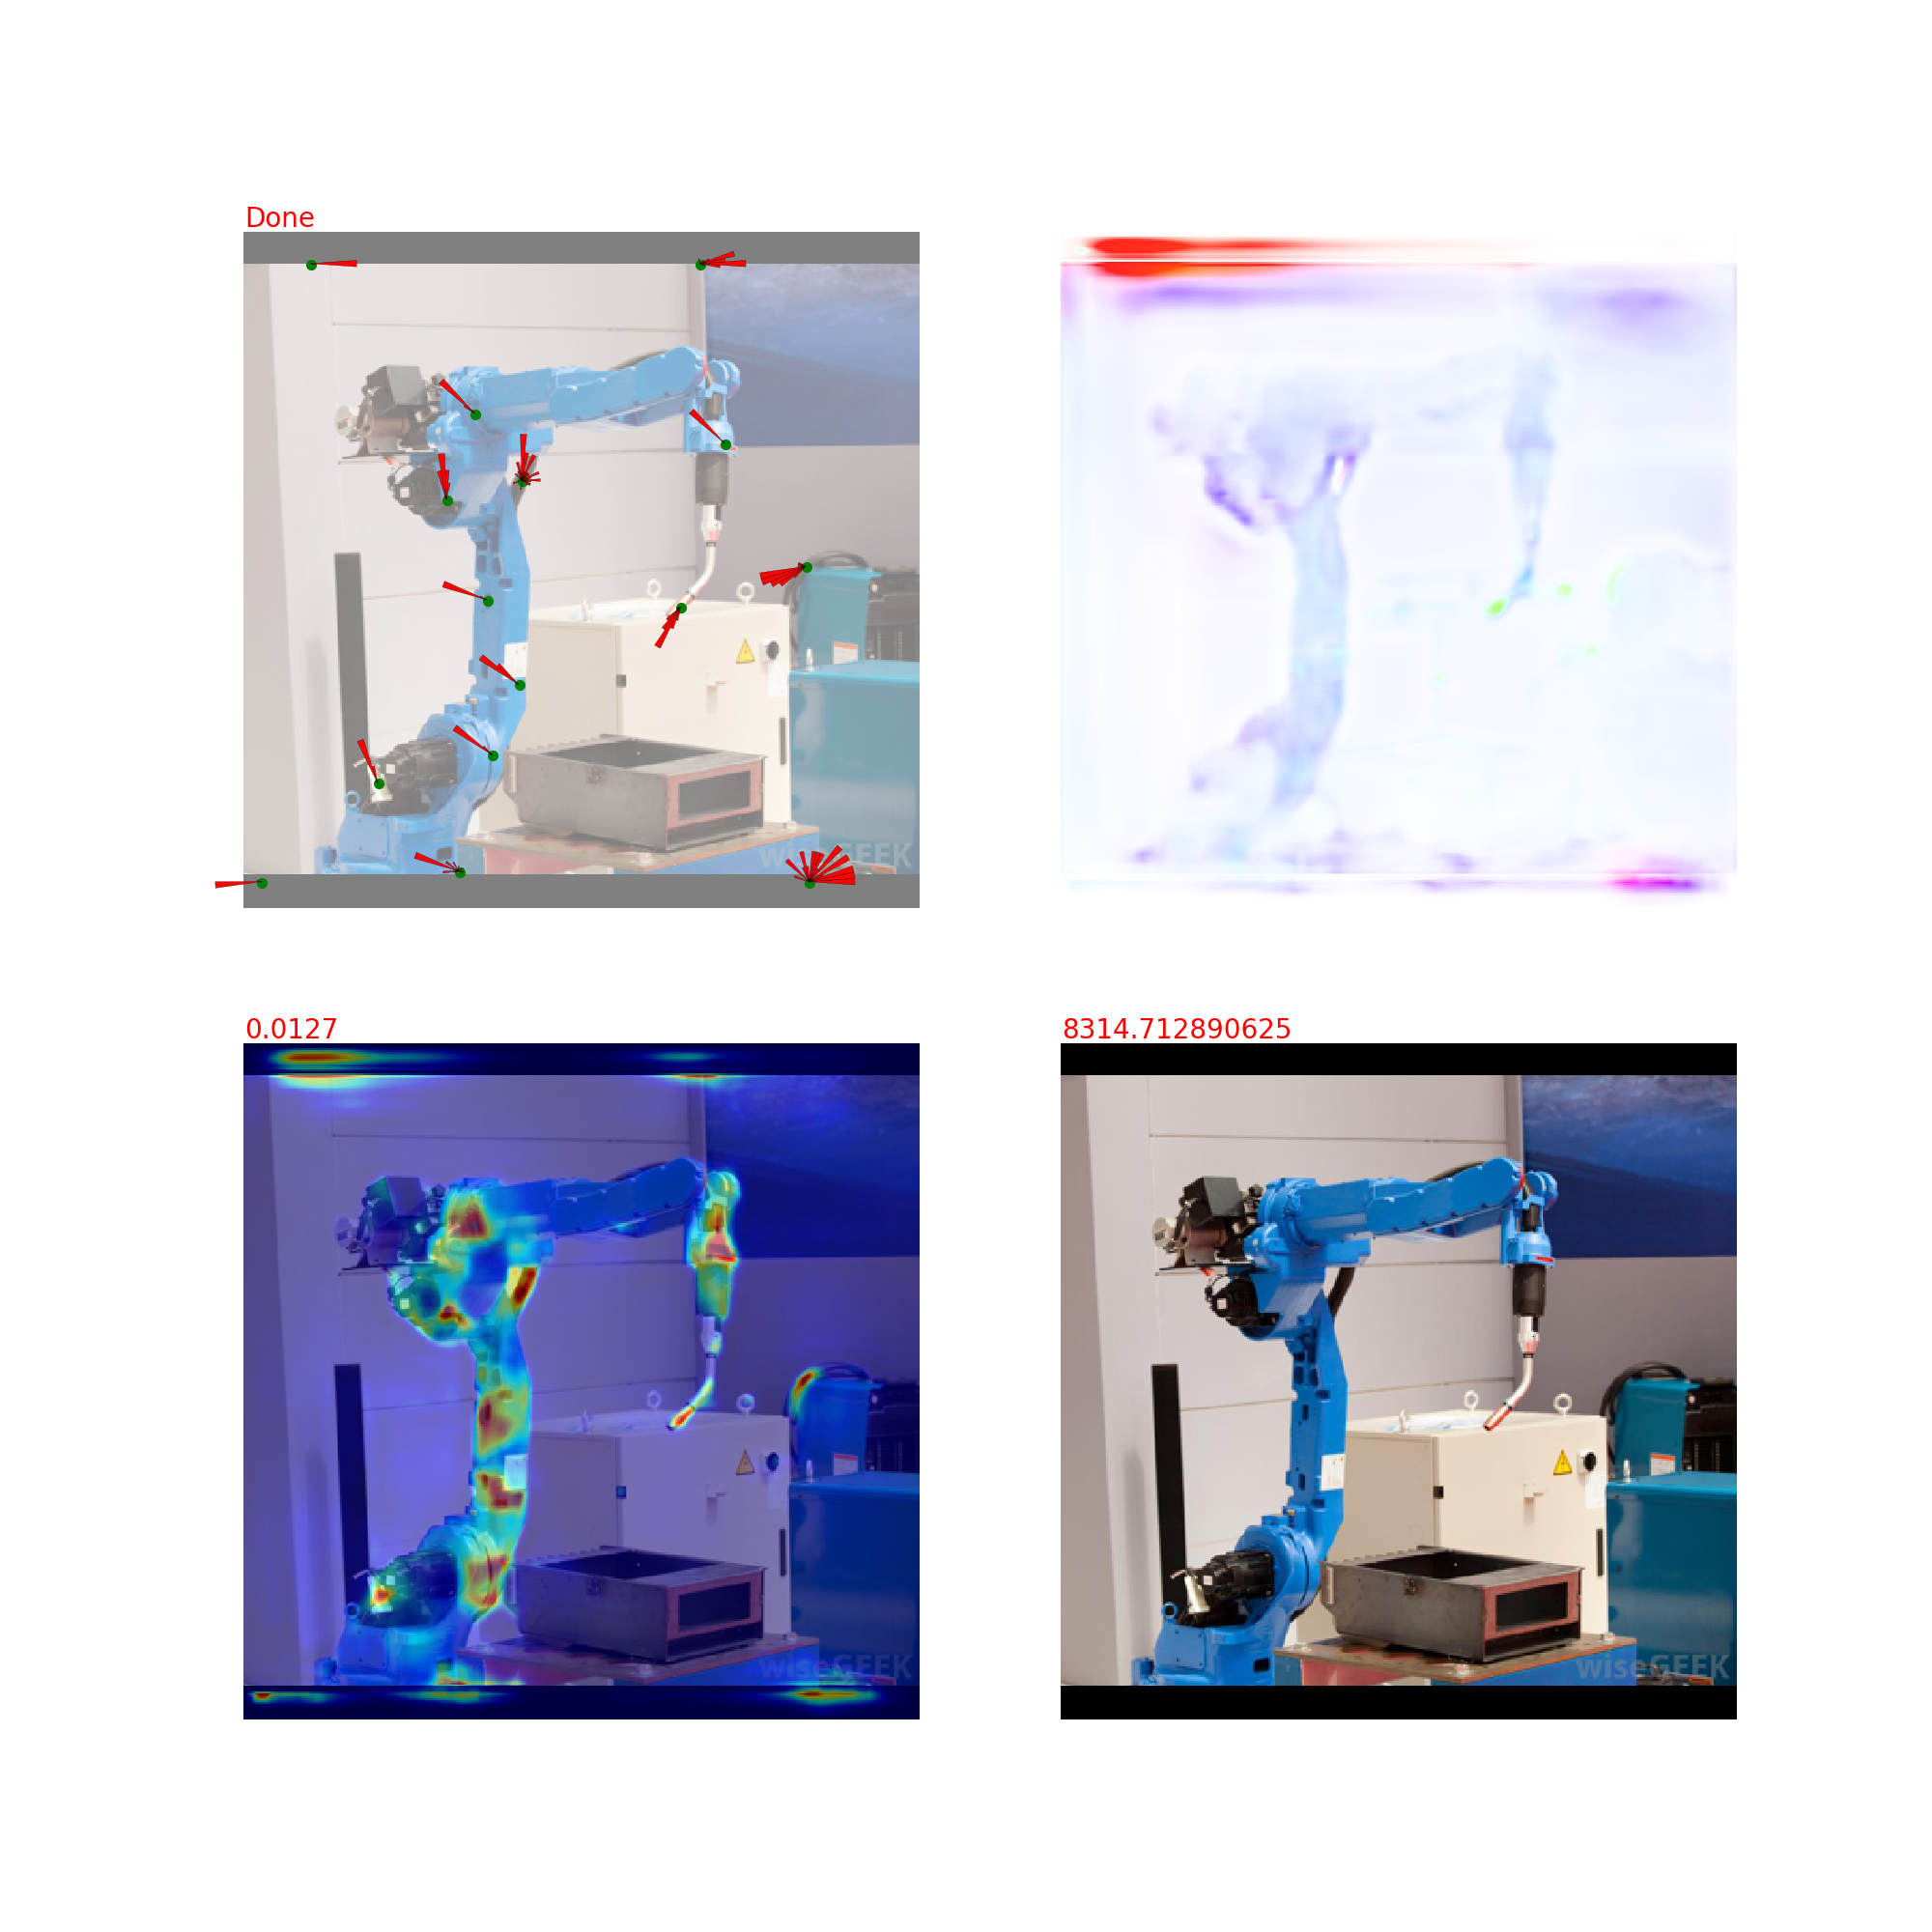

In [40]:
seed = np.random.randn(1,128)

fn = '/mnt/lustre/share/panxingang/VIP/group1/videos9/000000000801/000000000798.jpg'
fn = '/mnt/lustre/share/panxingang/MPII/videos/1/082125730/00000057.jpg'
fn = '/mnt/lustre/share/panxingang/boston-dynamics-spotmini.jpg'
fn = '/mnt/lustre/share/panxingang/drop.jpg'

image_from = 'fn'
#url = 'https://assets3.thrillist.com/v1/image/2790981/size/sk-2017_04_featured_listing_mobile.jpg'
#url = 'https://media.wired.com/photos/5bc0adcc2ba3661093860d0a/master/pass/spotmini-975475584.jpg'
#url = 'https://fortunedotcom.files.wordpress.com/2018/07/boston-dynamics-spotmini.jpg?w=1024'
#url = 'https://cdn.vox-cdn.com/thumbor/wbyMOoUjjPEFT3-j2V6CwTTkvzs=/1400x1400/filters:format(png)/cdn.vox-cdn.com/uploads/chorus_asset/file/13278771/Screen_Shot_2018_10_16_at_3.29.50_PM.png'
#url = 'http://www.fsf.org.uk/assets/Uploads/_resampled/croppedimage613299-fans-jon-candy-flickr-cc.jpg'
#fn = fns[idx] # mpii: 5， 10
fn = '/mnt/lustre/share/panxingang/arm5.jpg'

idx = fn.split('/')[-1][:-4]

#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos1/000000000001/000000000004.jpg'
#fn = '/mnt/lustre/share/zhanxiaohang/data/images/hand.jpg'
#fn = '/mnt/lustre/share/panxingang/hand4.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos9/000000001326/000000001334.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos9/000000000901/000000000908.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos21/000000001776/000000001775.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos11/000000000101/000000000105.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos16/000000001151/000000001143.jpg'
#fn = '/mnt/lustre/share/panxingang/VIP/group1/videos2/000000000976/000000000966.jpg'

#fn = '/mnt/lustre/share/zhanxiaohang/data/images/16.jpg'
#fn = '/mnt/lustre/share/zhanxiaohang/data/images/21.png'
#fn = '/mnt/lustre/share/zhanxiaohang/data/images/20.png'
#fn = '/mnt/lustre/share/zhanxiaohang/data/images/18.jpg'
#fn = '/mnt/lustre/share/zhanxiaohang/data/images/19.png'

# traffic
#fn = '/mnt/lustre/share/panxingang/GRAM/images/M-30/image000012.jpg'

# horse
#fn = '/mnt/lustre/share/panxingang/tigdog/images/horse/00037276.jpg'
if image_from == 'url':
    response = requests.get(fn)
    img = Image.open(BytesIO(response.content))
else:
    img = Image.open(fn).convert("RGB")


hid_z = seed.copy().astype(np.float32)
#hid_z[0,0] = 0
#hid_z=None

if setting in ['i', 'is', 'if']:
    max_iter = 1
else:
    max_iter = 15
if exp == '../experiments/vip+mpii/cmpvae_skiplayer_fw_nobg':
    short_size = -1
    long_size = None
else:
    short_size = None
    long_size = -1
    
obj.init_image(img, idx, np.array(range(128), dtype=np.int64),
               iter_mode=True, masked=True, show_flow=False, max_iter=max_iter, score_th=0.003,
               short_size=short_size, long_size=long_size, crop_size=None, hid_z=hid_z)
obj.run()
